<a href="https://colab.research.google.com/github/jylin04/mi-ntk/blob/main/tms_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NTK <> TMS

In this notebook, I'll replicate some results from [TMS](https://transformer-circuits.pub/2022/toy_model/index.html) and [Superposition, Memorization and Double Descent](https://transformer-circuits.pub/2023/toy-double-descent/index.html), then study NTK-inspired hypotheses for feature learning in an instance of TMS where the empirical NTK is a good approximation.

# Setup (run this cell at start)

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import numpy as np
import torch as t
import matplotlib.pyplot as plt

from torch import nn, Tensor
from torch.nn import functional as F

from tqdm.notebook import tqdm

In [4]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from matplotlib.colors import LinearSegmentedColormap

In [5]:
%pip install -q git+https://github.com/jylin04/mi-ntk.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [6]:
import tms, tms_fixed, ntk

from tms import ReluModel
from tms import generate_batch, importance_weighted_loss, train_tms
from tms_fixed import generate_batch_with_norm, train_tms_fixed
from ntk import empirical_ntk, LinearisedPredictor, loss_acc_gap, r2_score

In [7]:
# cfg
epochs: int = 5000
batch_size: int = 1024
lr: float = 1e-3
n_features: int = 80
n_hidden: int = 20
sparsity: float = 0.9
importance: float = 0.9

device = t.device("cuda" if t.cuda.is_available() else "cpu")
seed = 0

t.manual_seed(seed)

# 1. Replicate TMS baseline

Training loop.

In [ ]:
model = ReluModel(n_features=80, n_hidden=20).to(device)
optimizer = t.optim.Adam(model.parameters(), lr=lr)

In [ ]:
for step in tqdm(range(epochs)):
  train_loss = train_tms(model, optimizer, batch_size, n_features=80, S = 0.9, I = 0.9, device=device)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

  0%|          | 0/2001 [00:00<?, ?it/s]

Epoch 0: Train loss 0.0031
Epoch 1000: Train loss 0.0003
Epoch 2000: Train loss 0.0002


Visualizing the results:

In [90]:
def plot_weights(W, pytorch=True):
   ''' Do (1) for an individual weight matrix '''
   if pytorch:
    W = W.detach().cpu().numpy()
   plt.imshow(W.T @ W, vmin=-1.3, vmax=1.3, cmap="RdBu_r")

In [91]:
def plot_norms(W, pytorch=True):
    ''' Do (2) for an individual weight matrix '''
    if pytorch:
      W = W.detach().cpu().numpy()

    n_hidden, n_features = W.shape                        # SHape is e.g. [5, 20]

    W_norm = W /(1e-5 + np.linalg.norm(W, axis=0))        # Shape is e.g. [5, 20], but each of the 20 vectors has been normalized in the [5] direction]

    superposition = np.zeros(n_features)
    for i in range(n_features):
      for j in range(n_features):
        if i != j:
          superposition[i] += (W_norm.T[i] @ W.T[j])**2

    colors = ["purple" if sup <=0.01 else "yellow" for sup in superposition]

    norms = np.linalg.norm(W, axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(2, 10))

    ax.barh(np.arange(len(norms)), norms, align='center', color=colors, alpha=0.8)
    ax.set_yticks([])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xticks([])

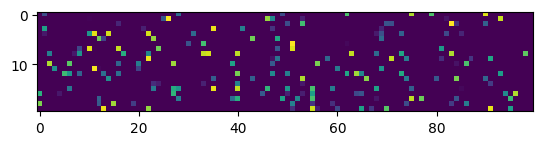

In [ ]:
# Visualize the dataset
plt.imshow(generate_batch(100, 20, 0.9).T)
plt.show();

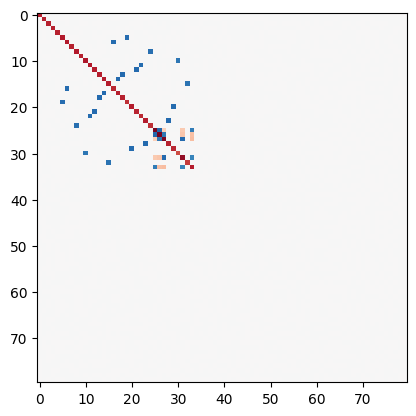

In [ ]:
plot_weights(model.W)

In [ ]:
# Find the number of features that the autoencoder can reconstruct

for x in range(n_features):
  if (model.W.T @ model.W)[x,x] < 0.01:
    print(x)
    break

34


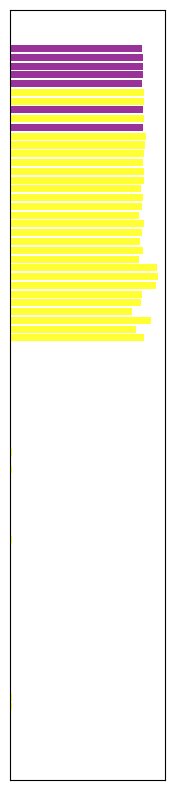

In [ ]:
plot_norms(model.W)

# 2. Replicate "Superposition, Memorization & Double Descent"

Next, we'd like to redo the TMS experiment with a fixed, normalized dataset.

In [7]:
# cfg

batch_size: int = 100
n_features: int = 10   # <- replicates the plots in Marius Hobbhahn's LW post
n_hidden: int = 5
sparsity: float = 0.9
importance: float = 0.8

epochs = 2001

Training loop.

In [8]:
# Use one fixed dataset for all epochs
dataset = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model.parameters(), lr = lr)

In [9]:
for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model, dataset, optimizer, importance)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

  0%|          | 0/2001 [00:00<?, ?it/s]

Epoch 0: Train loss 0.0135
Epoch 1000: Train loss 0.0003
Epoch 2000: Train loss 0.0001


Plots of the trained parameters.

(What exactly are we plotting here?:

- In "features": the 1000 vectors that map each of 1000 1-hot-encoded input vectors (features) to the hidden space.

- In "hidden vectors": the representation of each of the 1000 entries of the fixed dataset in the hidden space.)

In [130]:
W = model.W.detach().cpu().numpy()
hidden_vectors = W @ dataset.T.detach().cpu().numpy()

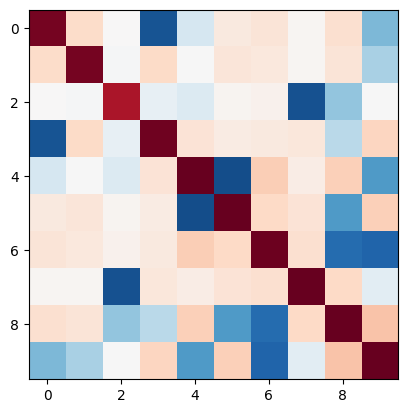

In [131]:
plot_weights(W, False)

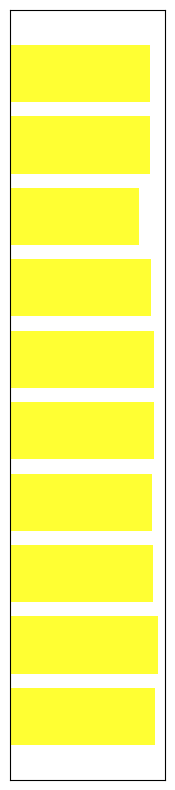

In [132]:
plot_norms(W, False)

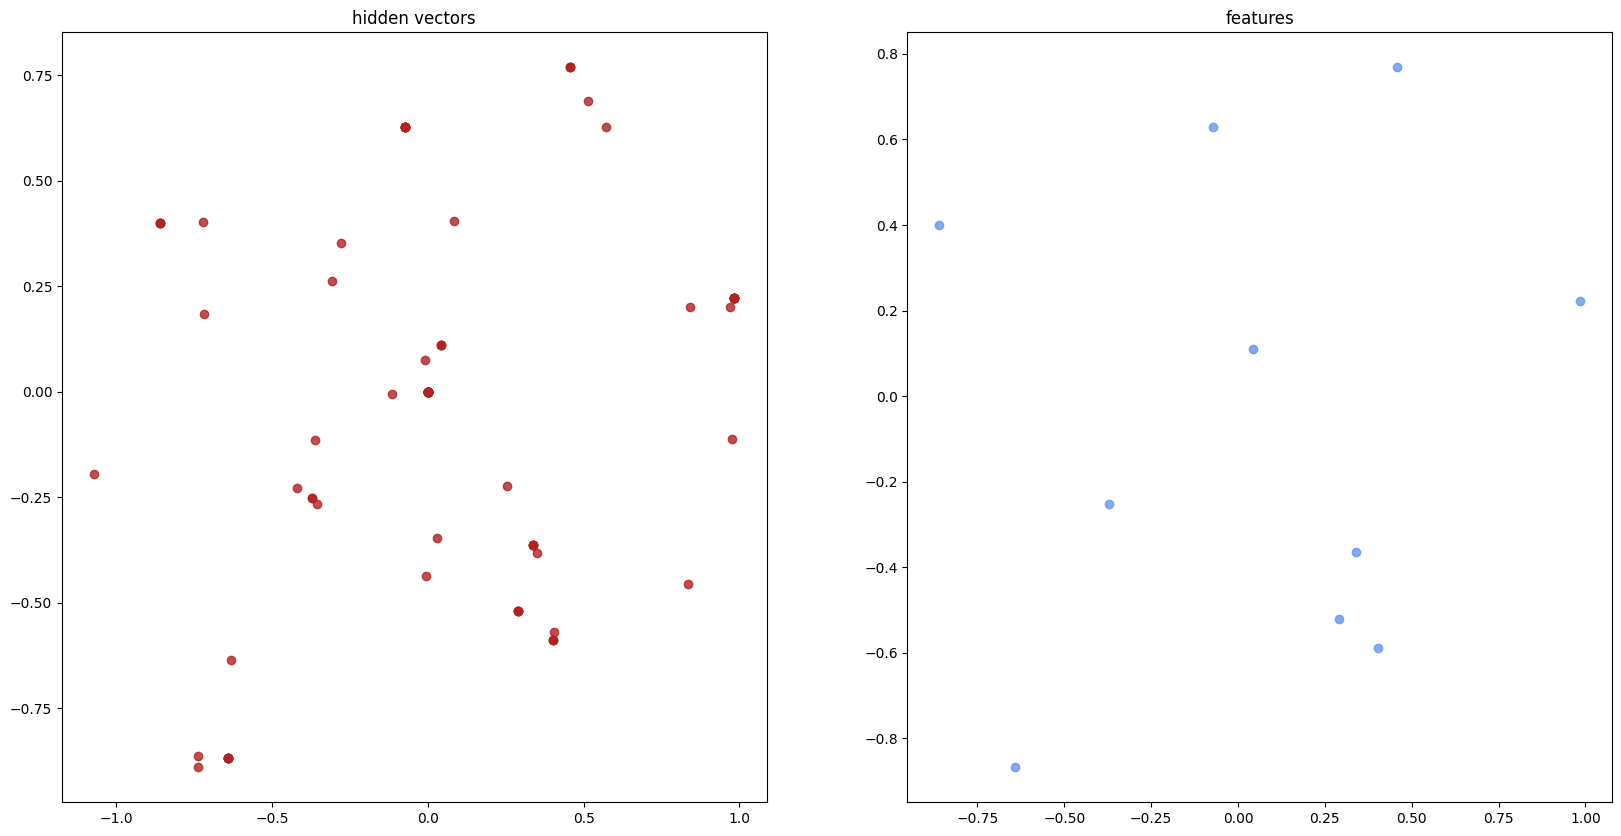

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].scatter(hidden_vectors[0], hidden_vectors[1], color="firebrick", alpha=0.8)
ax[0].set_title("hidden vectors")

ax[1].scatter(W[0], W[1], color="cornflowerblue", alpha=0.8)
ax[1].set_title("features")

plt.show();

Double descent curve when sweeping over different dataset sizes.

In [29]:
data_sizes = [3, 5, 8, 10, 15, 30, 50, 100, 200, 500, 1000] #, 2000] #, 5000, 10000, 20000]

n_features: int = 50
n_hidden: int = 10
sparsity: float = 0.9
importance: float = 0.8

epochs: int = 3001

In [30]:
train_sets = []
test_sets = []
train_losses = []
test_losses = []
weights = []

In [31]:
for i in tqdm(range(len(data_sizes))):

  dataset_size = data_sizes[i]

  model = ReluModel(n_features, n_hidden).to(device)
  dataset = generate_batch_with_norm(dataset_size, n_features, sparsity).to(device)
  optimizer = t.optim.Adam(model.parameters(), lr = lr)

  for step in range(epochs):
    train_loss = train_tms_fixed(model, dataset, optimizer, importance)
#    if (step % 1000 == 0):
#      print(f"Epoch {step}: Train loss {train_loss:.4f}")

  test_set = generate_batch_with_norm(dataset_size, n_features, sparsity).to(device)

  train_losses.append(train_loss.item())
  test_losses.append(importance_weighted_loss(test_set, model(test_set), t.tensor(importance, device=test_set.device)**t.arange(n_features, device = test_set.device)).item()*1000)
  train_sets.append(dataset.detach().cpu().numpy())
  test_sets.append(test_set.detach().cpu().numpy())
  weights.append(model.W.detach().cpu().numpy())

  0%|          | 0/11 [00:00<?, ?it/s]

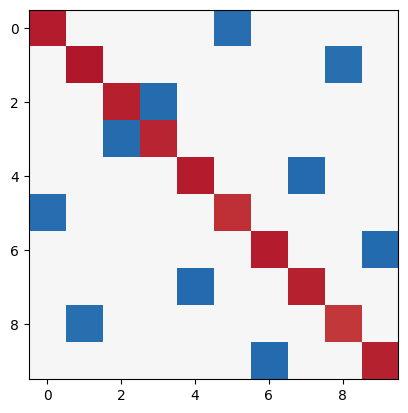

In [ ]:
plot_weights(weights[10], False)

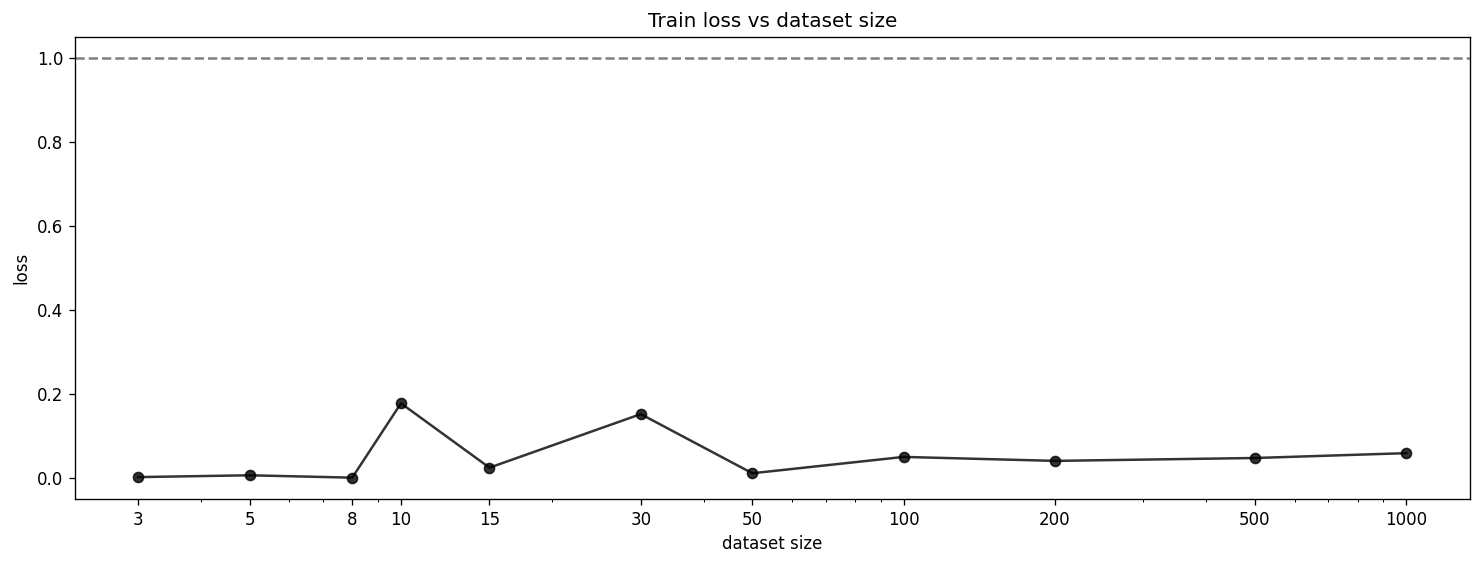

In [32]:
scalar = 1000
train_losses_scaled = [a*scalar for a in train_losses]

fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=120)

ax.axhline(1, linestyle="--", color="grey")
ax.set_ylabel("loss")
ax.set_xlabel("dataset size")
ax.plot(data_sizes, train_losses_scaled, '-o', color="black", alpha=0.8)
ax.set_xscale("log")
ax.set_title("Train loss vs dataset size")

ax.set_xticks(data_sizes)
ax.set_xticklabels(data_sizes)

plt.show();

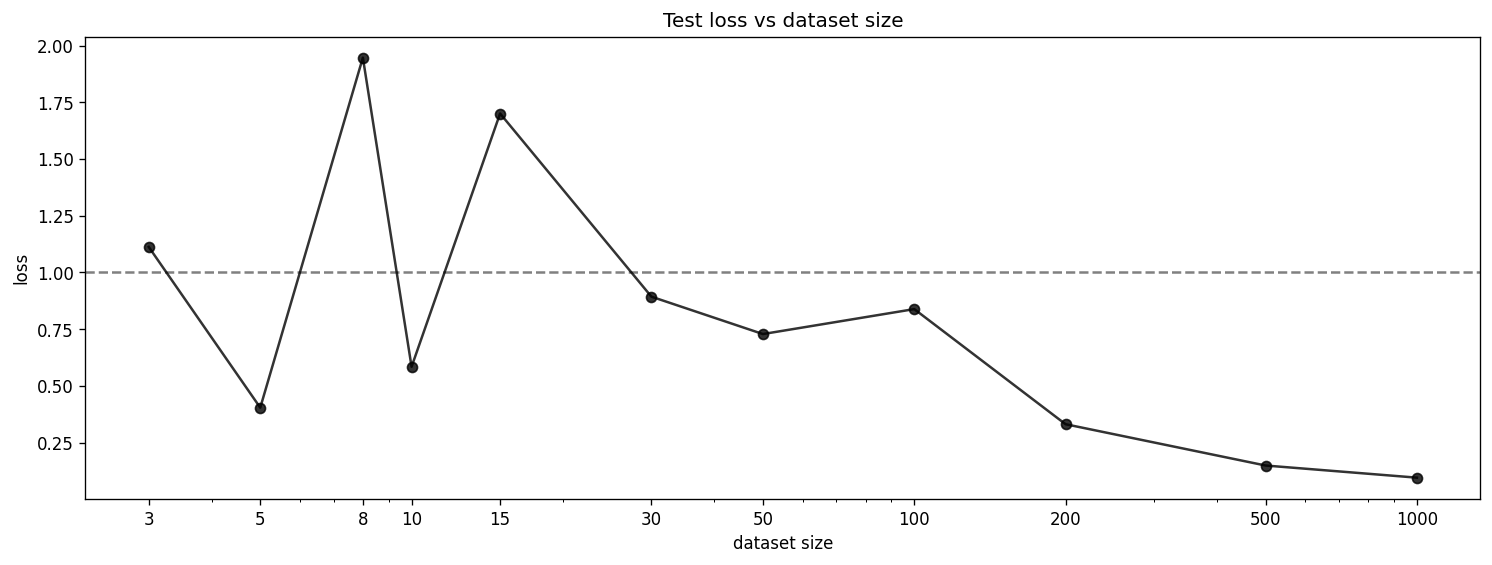

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=120)

ax.axhline(1, linestyle="--", color="grey")
ax.set_ylabel("loss")
ax.set_xlabel("dataset size")
ax.plot(data_sizes, test_losses, '-o', color="black", alpha=0.8)
ax.set_xscale("log")
ax.set_title("Test loss vs dataset size")

ax.set_xticks(data_sizes)
ax.set_xticklabels(data_sizes)

plt.show();

Using Marius Hobbhahn's code to visualize the features and training set hidden vectors:

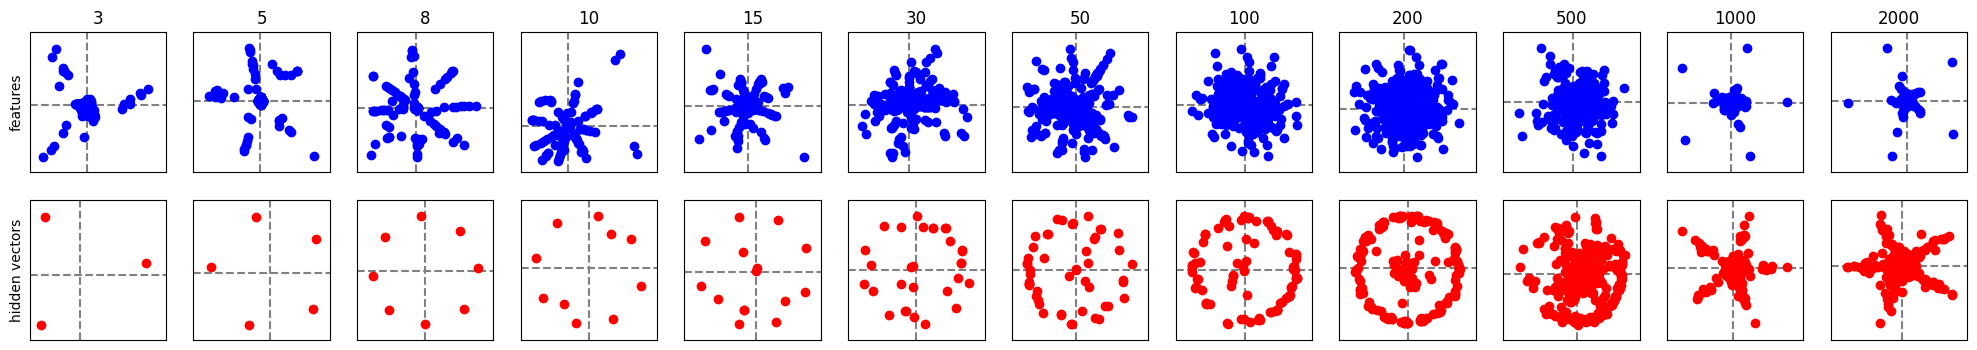

In [ ]:
#### visualize features

## think about centering each plot at 0

fig, ax = plt.subplots(2, len(data_sizes), figsize=(25, 4))
c = 1.3

ax[0][0].set_ylabel("features")
ax[1][0].set_ylabel("hidden vectors")

hidden_vectors_list = []

for i in range(len(data_sizes)):

    W = weights[i]
    inputs = train_sets[i]
    s = data_sizes[i]

    hidden_vectors = W @ inputs.T
    hidden_vectors_list.append(hidden_vectors)

    ax[0][i].scatter(W[0], W[1], color="blue", alpha=1)
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    ax[0][i].set_xlim(c*W[0].min().item(), c*W[0].max().item())
    ax[0][i].set_ylim(c*W[1].min().item(), c*W[1].max().item())
    ax[0][i].set_title(str(s))
    ax[0][i].axvline(0, linestyle="--", color="grey", zorder=-1)
    ax[0][i].axhline(0, linestyle="--", color="grey", zorder=-1)

    ax[1][i].scatter(hidden_vectors[0], hidden_vectors[1], color="red", alpha=1)
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])
    ax[1][i].set_xlim(c*hidden_vectors[0].min().item(), c*hidden_vectors[0].max().item())
    ax[1][i].set_ylim(c*hidden_vectors[1].min().item(), c*hidden_vectors[1].max().item())
    ax[1][i].axvline(0, linestyle="--", color="grey", zorder=-1)
    ax[1][i].axhline(0, linestyle="--", color="grey", zorder=-1)

plt.show();

# 3. Check empirical NTK for TMS with various hyperparameters.

Let's check that the empirical NTK is a good approximation for a few models that we can then try to interpret.

(Since we only need one or two specific models to work with *and* for a given choice of (m,n) we have to manually check that (S, I) gives a reasonable double descent curve, let's check select models one at a time until we have one or two that work, rather than doing a thorough hyperparameter sweep.)

### Choice 1: D=100, n=10, m = 5, S = 0.9, I = 0.8

In [22]:
batch_size: int = 100
n_features: int = 10
n_hidden: int = 5
sparsity: float = 0.9
importance: float = 0.8

epochs = 5000

dataset = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model.parameters(), lr = lr)

for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model, dataset, optimizer, importance)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0: Train loss 0.0137
Epoch 1000: Train loss 0.0004
Epoch 2000: Train loss 0.0003
Epoch 3000: Train loss 0.0003
Epoch 4000: Train loss 0.0001


In [23]:
linearized_model = LinearisedPredictor(model, dataset, dataset, ridge = 1e-5)
(loss_acc_gap(model, linearized_model, dataset, dataset, expand_around_model=True), r2_score(model, linearized_model, dataset, expand_around_model=True))

((0.7212332593095186, 0.0), tensor(0.9986, device='cuda:0'))

In [24]:
(loss_acc_gap(model, linearized_model, dataset, dataset, expand_around_model=False), r2_score(model, linearized_model, dataset, expand_around_model=False))

((0.7217997166081065, 0.0), tensor(0.9987, device='cuda:0'))

ChatGPT (o3) suggests cutoffs of <=1.10 loss ratio (acceptable: 1.1-1.3), <= 2pp accuracy gain (acceptable: 2pp-5pp) and R2 score >=0.8.

These hyperparameters put us squarely in this range. In fact, the eNTK approximation does better than the real model.

The eNTK approximation does about equally well in the pure NTK and when we linearize around the trained model.

#### Sanity check that it's stable to a larger dataset: D=1000, n=10, m = 5, S = 0.9, I = 0.8

In [11]:
batch_size: int = 1000
n_features: int = 10
n_hidden: int = 5
sparsity: float = 0.9
importance: float = 0.8

epochs = 5000

dataset = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model.parameters(), lr = lr)

for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model, dataset, optimizer, importance)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0: Train loss 0.0207
Epoch 1000: Train loss 0.0010
Epoch 2000: Train loss 0.0008
Epoch 3000: Train loss 0.0008
Epoch 4000: Train loss 0.0008


Now at ridge parameter 1e-5, the result is numerically unstable, possibly because the larger dataset size -> smaller NTK eigenvalues on the tail. But at the ~smallest ridge parameter OOM where the metrics aren't terrible, they seem reasonable.

Note that if we keep cranking *up* the ridge parameter we get good metrics but are probably killing off all the fine-grained structure.

In [12]:
linearized_model = LinearisedPredictor(model, dataset, dataset, ridge = 1e-4)
(loss_acc_gap(model, linearized_model, dataset, dataset, expand_around_model=True), r2_score(model, linearized_model, dataset, expand_around_model=True))

((1.245384489874358, 0.700002908706665), tensor(0.9913))

In [13]:
(loss_acc_gap(model, linearized_model, dataset, dataset, expand_around_model=False), r2_score(model, linearized_model, dataset, expand_around_model=False))

((1.1662084054387363, 0.40000081062316895), tensor(0.9937))

In [14]:
linearized_model = LinearisedPredictor(model, dataset, dataset, ridge = 1)
(loss_acc_gap(model, linearized_model, dataset, dataset, expand_around_model=True), r2_score(model, linearized_model, dataset, expand_around_model=True))

((0.9919644397523286, -0.09999871253967285), tensor(0.9997))

### Choice 2 [if we want more features]: D=500, n=50, m = {5 or 10}, S = 0.9, I = 0.8

In [38]:
batch_size: int = 500
n_features: int = 50
n_hidden: int = 5
sparsity: float = 0.9
importance: float = 0.8

epochs = 5001

dataset = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model.parameters(), lr = lr)

for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model, dataset, optimizer, importance)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

  0%|          | 0/5001 [00:00<?, ?it/s]

Epoch 0: Train loss 0.0017
Epoch 1000: Train loss 0.0002
Epoch 2000: Train loss 0.0002
Epoch 3000: Train loss 0.0002
Epoch 4000: Train loss 0.0002
Epoch 5000: Train loss 0.0002


In [39]:
linearized_model = LinearisedPredictor(model, dataset, dataset, ridge = 1e-4)
(loss_acc_gap(model, linearized_model, dataset, dataset, expand_around_model=True), r2_score(model, linearized_model, dataset, expand_around_model=True))

((0.9993309602922036, 1.600000262260437), tensor(0.9344, device='cuda:0'))

In [40]:
(loss_acc_gap(model, linearized_model, dataset, dataset, expand_around_model=False), r2_score(model, linearized_model, dataset, expand_around_model=False))

((0.9987342335383874, 2.400001883506775), tensor(0.9303, device='cuda:0'))

From ridge=1e-5 to 1e-4, the R^2 increases monotonically from very negative to what we see here.

In [53]:
batch_size: int = 500
n_features: int = 50
n_hidden: int = 10
sparsity: float = 0.9
importance: float = 0.8

epochs = 5001

dataset = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model.parameters(), lr = lr)

for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model, dataset, optimizer, importance)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

  0%|          | 0/5001 [00:00<?, ?it/s]

Epoch 0: Train loss 0.0015
Epoch 1000: Train loss 0.0001
Epoch 2000: Train loss 0.0000
Epoch 3000: Train loss 0.0000
Epoch 4000: Train loss 0.0000
Epoch 5000: Train loss 0.0000


In [54]:
linearized_model = LinearisedPredictor(model, dataset, dataset, ridge = 1e-4)
(loss_acc_gap(model, linearized_model, dataset, dataset, expand_around_model=True), r2_score(model, linearized_model, dataset, expand_around_model=True))

((0.9879742478843584, 1.2000024318695068), tensor(0.9587, device='cuda:0'))

In [55]:
(loss_acc_gap(model, linearized_model, dataset, dataset, expand_around_model=False), r2_score(model, linearized_model, dataset, expand_around_model=False))

((0.9881908439223093, 1.3999998569488525), tensor(0.9594, device='cuda:0'))